In [20]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from math import sqrt
from sklearn.metrics import mean_squared_error
import numpy as np
import geoviews as gv
import geoviews.tile_sources as gvts
import xarray as xr


## Загрузка Данных ##

In [4]:
# Указываем путь к директории
directory = "C:/Users/Yakov.Chibinin/Documents/_notebook/waki/weather_data"
 
# Создаем пустой список
files = []
 
# Добавляем файлы в список
files += os.listdir(directory)
 
# Выводим список файлов
print(files)

['cheremushki,-moscow, moscow, russia-air-quality.csv', 'dolgoprud,-moscow, moscow, russia-air-quality.csv', 'glebovskaya,-moscow, moscow, russia-air-quality.csv', 'guryanova,-moscow, moscow, russia-air-quality.csv', 'hamovniki,-moscow, moscow, russia-air-quality.csv', 'kojuhovo,-moscow, moscow, russia-air-quality.csv', 'koptevo,-moscow, moscow, russia-air-quality.csv', 'marin,-moscow, moscow, russia-air-quality.csv', 'melitopolskaya,-moscow, moscow, russia-air-quality.csv', 'mgu,-moscow, moscow, russia-air-quality.csv', 'mkad-52-km-zapad,-moscow, moscow, russia-air-quality.csv', 'narod_op,-moscow, moscow, russia-air-quality.csv', 'novokosino,-moscow, moscow, russia-air-quality.csv', 'ochakovskaya,-moscow, moscow, russia-air-quality.csv', 'ostankino,-moscow, moscow, russia-air-quality.csv', 'parkovaya,-moscow, moscow, russia-air-quality.csv', 'proletarskiy,-moscow, moscow, russia-air-quality.csv', 'shabol,-moscow, moscow, russia-air-quality.csv', 'spirid,-moscow, moscow, russia-air-qua

In [5]:
def process_file(file):
    weather_file = pd.read_csv(f'weather_data/{file}')
    columns = weather_file.columns
    #транспонируем для вычисления максимума
    numeric  = weather_file[columns[1:]].T
    ## преообазуем и очищаем 
    for column in numeric.columns:
        numeric[column] = pd.to_numeric(numeric[column], errors='coerce')
    numeric.fillna(0)
    
    #получаем максимум 
    weather_file['aqi'] = numeric.max()
    weather_file['valid'] = numeric.min()
    
    weather_file['date'] = pd.to_datetime(weather_file['date'])
    district = file.split(',')[0]
    weather_file['station'] = district
    
    return weather_file[['station','date','aqi']]
     
    
frames = [process_file(f) for f in files]
result = pd.concat(frames, ignore_index=True )

## Анализ ##

In [6]:
pivot = result.pivot_table(index = 'date', columns = 'station', values = 'aqi')

In [7]:
pivot.head()

station     cheremushki  dolgoprud  glebovskaya  guryanova  hamovniki  \
date                                                                    
2013-12-31          1.0        2.0          NaN        NaN        NaN   
2014-01-01          5.0       11.0          NaN        NaN        NaN   
2014-01-02          3.0       13.0          NaN        NaN        NaN   
2014-01-03          8.0       22.0          NaN        NaN        NaN   
2014-01-04          6.0       25.0          NaN        NaN        NaN   

station     kojuhovo  koptevo  marin  melitopolskaya   mgu  ...  proletarskiy  \
date                                                        ...                 
2013-12-31       6.0      NaN   16.0             NaN  16.0  ...           NaN   
2014-01-01      20.0      NaN   21.0             NaN  17.0  ...           NaN   
2014-01-02       9.0      NaN   13.0             NaN  11.0  ...           NaN   
2014-01-03      12.0      NaN   16.0             NaN  15.0  ...           NaN   
2014-01-04      13.0      NaN   18.0             NaN  16.0  ...           NaN   

station     shabol  spirid  turist  vernad  veshnyaki  zelen_11  zelen_15  \
date                                                                        
2013-12-31     6.0    24.0     1.0     NaN        1.0       5.0       9.0   
2014-01-01    20.0    21.0     2.0     NaN        9.0      14.0      19.0   
2014-01-02    11.0    15.0     3.0     NaN        9.0      15.0      19.0   
2014-01-03    19.0    14.0     5.0     NaN       10.0      18.0      12.0   
2014-01-04    20.0    16.0     4.0     NaN       13.0      21.0      13.0   

station     zhulebino  сухаревка  
date                              
2013-12-31        NaN        2.0  
2014-01-01        NaN       17.0  
2014-01-02        NaN       14.0  
2014-01-03        NaN       14.0  
2014-01-04        NaN       15.0  

[5 rows x 26 columns]

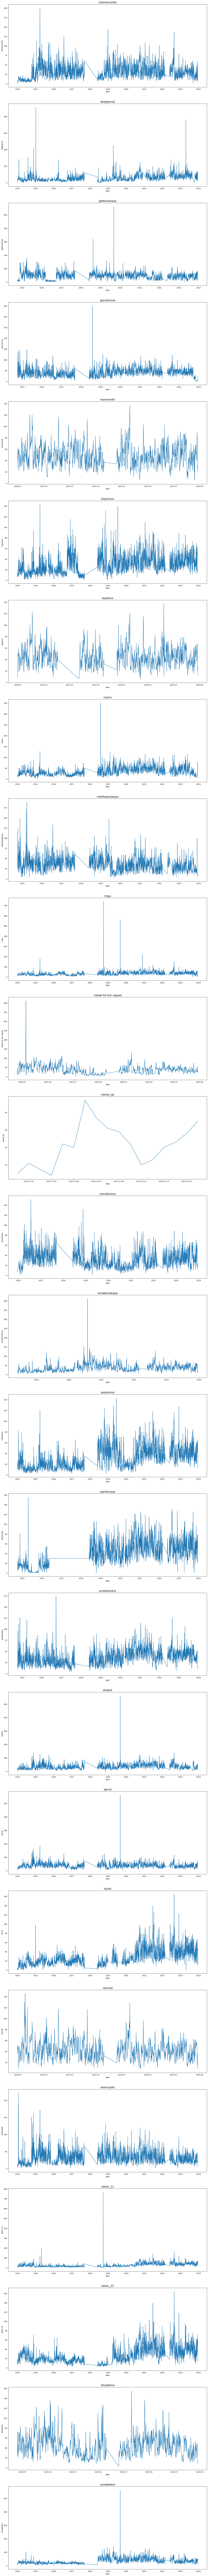

In [10]:
stations = pivot.columns
fig, axes = plt.subplots(nrows=len(pivot.columns), ncols=1, figsize=(20, len(pivot.columns) * 10))
ax_count = 0
for station in stations:
    sns.lineplot(
        data=pivot[station],
        ax=axes[ax_count]
    );
    axes[ax_count].set_title(station, fontsize=16)
    ax_count +=1

## Корректность предсказания ##

Test RMSE: 12.989


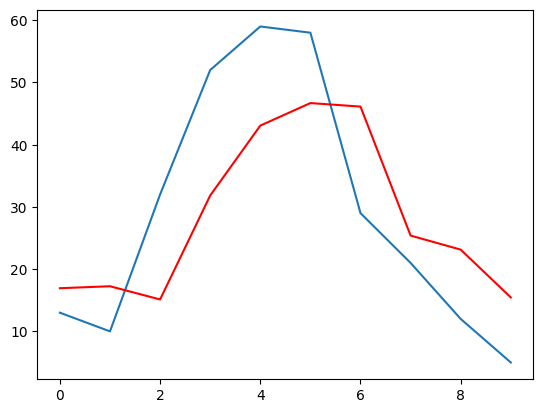

In [8]:
#Валидность выбранной моделт
series = pivot['cheremushki']
X = series.values
size = len(X)-10
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# evaluate forecastsabs
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Предсказание для каждого значения

In [11]:
predicted = []
last = []
for station in stations:
    series = pivot[station]
    X = series.values
    model = ARIMA(X, order=(10,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    predicted.append(output[0])
    last.append(X[-1])
    
stations_predicted = pd.DataFrame({'station':stations,
                          'last':last,
                         'predicted':predicted})

C:\Users\Yakov.Chibinin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Yakov.Chibinin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
stations_predicted

station  last  predicted
0        cheremushki   5.0  12.509373
1          dolgoprud  13.0  25.135072
2        glebovskaya  10.0  26.419312
3          guryanova   NaN  20.258671
4          hamovniki  19.0  29.559585
5           kojuhovo   NaN  27.943804
6            koptevo  13.0  22.453422
7              marin   4.0  12.095878
8     melitopolskaya   NaN  16.334679
9                mgu   9.0  23.194447
10  mkad-52-km-zapad  24.0  26.798025
11          narod_op   NaN  27.027904
12        novokosino   NaN  29.556297
13      ochakovskaya   9.0  22.664636
14         ostankino  13.0  22.333478
15         parkovaya  21.0  30.627831
16      proletarskiy   NaN  27.332511
17            shabol   5.0  17.829607
18            spirid  11.0  25.240516
19            turist  11.0  21.649520
20            vernad   9.0  23.171659
21         veshnyaki   7.0  14.684884
22          zelen_11   NaN  37.916397
23          zelen_15   NaN  27.377756
24         zhulebino   7.0  15.424749
25         сухаревка   8.0  18.943820

## Постобработка полученных значений ##

In [13]:
stations_predicted = stations_predicted.dropna()

In [14]:
coordinates = pd.read_csv('26stations.csv')
coordinates['station'] = coordinates['station'].apply(lambda x: x.split(',')[0].lower())
coordinates.head()

station   latitude  longitude
0        novokosino  55.734445  37.857779
1    melitopolskaya  55.535478  37.579360
2      proletarskiy  55.635129  37.658684
3         hamovniki  55.718774  37.570271
4  mkad-52-km-zapad  55.703489  37.397577

In [15]:
fulldf = coordinates.merge(stations_predicted, how='inner')
fulldf['last'] = fulldf['last'].astype(int)
fulldf['predicted'] = fulldf['predicted'].astype(int)
fulldf

station   latitude  longitude  last  predicted
0          hamovniki  55.718774  37.570271    19         29
1   mkad-52-km-zapad  55.703489  37.397577    24         26
2          ostankino  55.821154  37.612592    13         22
3       ochakovskaya  55.693546  37.455579     9         22
4          veshnyaki  55.719959  37.795549     7         14
5             vernad  55.658163  37.471434     9         23
6             spirid  55.759354  37.595584    11         25
7            koptevo  55.833222  37.525158    13         22
8              marin  55.652695  37.751502     4         12
9          parkovaya  55.804364  37.839048    21         30
10               mgu  55.707241  37.522410     9         23
11         zhulebino  55.688043  37.863004     7         15
12            shabol  55.715698  37.605238     5         17
13       cheremushki  55.680056  37.584782     5         12
14       glebovskaya  55.811801  37.712490    10         26
15         dolgoprud  55.894383  37.536881    13         25
16            turist  55.856324  37.426628    11         21

## Рисуем сейчас - завтра ##

In [16]:
fulldf.to_csv('result.csv')

In [46]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    weights = 1.0 / dist

    weights /= weights.sum(axis=0)
        
    zi = np.dot(weights.T, z)
    return zi

latlngbox = "36.8,55.3,38.5,56.2"
latlngbox_num = list(map(float, latlngbox.split(',')))

lats = np.linspace(latlngbox_num[0], latlngbox_num[2], num=150)
lons = np.linspace(latlngbox_num[1], latlngbox_num[3], num=151)
meshgrid_shape = (lats.size, lons.size)

xi, yi = np.meshgrid(lons, lats)
xi, yi = xi.ravel(), yi.ravel()

def displaymap(dim):
    y,x = fulldf['longitude'].values, fulldf['latitude'].values
    z = fulldf[dim].values

    zi = simple_idw(x, y, z, xi, yi)
    zi = zi.reshape(meshgrid_shape)

    ds = xr.DataArray(zi, dims=['longitude', 'latitude'], coords={'longitude': lats, 'latitude': lons}).to_dataset(name=dim)

    aqi_ds = gv.Dataset(ds, ['longitude', 'latitude'], dim)

    return gvts.OSM * aqi_ds.to(gv.FilledContours, ['longitude', 'latitude']).opts(alpha=0.8, width=800, height=600,
                                                                  colorbar=True, cmap='magma', levels=20, color_levels=20,
                                                                  tools=['hover'])


In [50]:
gv.save(displaymap('last'), 'saved/last.html')
gv.save(displaymap('predicted'), 'saved/predicted.html')